In [96]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx

import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed 
set_random_seed(2)

from keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd
from pandas.plotting import autocorrelation_plot
import math as m
import os, glob


In [97]:
source_data = os.path.join(cwd, r'../../Models/2020/')
filenames = glob.glob(source_data + "/*.hdf5")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

06_04_2020_LSTM.hdf5


In [98]:
filename = filenames[0]
print(filename)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/../../Models/2020/06_04_2020_LSTM.hdf5


In [ ]:
# Leemos el modelo 
model = tf.keras.models.load_model(filepath)

In [86]:
#Leemos el dataset a probar

source_data = os.path.join(cwd, r'../../Datasets/EURUSD/ene2004_nov2019/')
filenames = glob.glob(source_data + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

EURUSD_ASK_01.01.2004-19.11.2019.csv
EURUSD_ASK_1_D_01.01.2004-19.11.2019.csv
EURUSD_ASK_1_H_01.01.2004-19.11.2019.csv
EURUSD_ASK_4_h_31.12.2003-18.11.2019.csv


In [87]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S.%f')
DF_EURUSD_ASK = pd.read_csv(filenames[0], parse_dates=['Gmt time'], date_parser=dateparse, index_col=None, header=0)
print(DF_EURUSD_ASK.columns)
DF_EURUSD_ASK.rename(columns={'Gmt time':'timestamp',
                             'Open':'open_ask',
                             'High':'high_ask',
                             'Low':'low_ask',
                             'Close':'close_ask',
                             'Volume':'volume_ask'},
                    inplace=True)
DF_EURUSD_ASK = DF_EURUSD_ASK.drop(['timestamp'], axis = 1)

#Moving Average  
def MA(df, n): 
    MA = pd.Series(df['close_ask'].rolling(n).mean(), name = 'MA_' + str(n)) 
    df = df.join(MA)  
    return df

# Se agrega la columna MA_25
DF_EURUSD_ASK = MA(DF_EURUSD_ASK, 25)
# Se agrega la columna MA_50
DF_EURUSD_ASK = MA(DF_EURUSD_ASK, 50)
DF_loc = DF_EURUSD_ASK.iloc[50:]
DF_Full = DF_loc

print(DF_Full.columns)
print(DF_Full.head())
print(DF_Full.shape)

RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 32

TEST_SIZE = .19
VAL_SIZE = .0
START_IN = 50000
END_IN = 60000

total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)
print('End: ', END_IN)

#Ajustamos indices de inicio y Final del Dataset
DF_Sub = DF_Full.iloc[START_IN:END_IN]
DF_Sub.reset_index(drop=True, inplace=True) #reset indexes from iloc
print('Shape :', DF_Sub.shape)
total = DF_Sub.shape[0]
print('Total: ', total)

#Generamos  VECTOR Y 'close_y'
close_y = DF_Sub['close_ask'].iloc[1:]
close_y.columns = ['close_y']
print(close_y.tail())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)

s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)

data_training = DF_Sub.iloc[:end_train]
data_val = DF_Sub.iloc[end_train: end_val]
data_test = DF_Sub.iloc[end_val:]

print("Data Training Shape: ",data_training.shape)
print("Data Val Shape: ",data_val.shape)
print("Data Test Shape: ",data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]
print("")
print("Y Data Training Shape: ", data_training_y.shape)
print("Y Data Val Shape: ", data_val_y.shape)
print("Y Data Test Shape: ", data_test_y.shape)

data_training_array = np.array(data_training)
#data_training_array = data_training_array.reset_index()
print(data_training_array.shape)
np.where(np.isnan(data_training_array))
#print(data_training_array.shape)
np.any(np.isnan(data_training_array))

DF_Sub.columns.get_loc('close_ask')
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
#data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)

X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape

X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape

#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape

X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Index(['open_ask', 'high_ask', 'low_ask', 'close_ask', 'volume_ask', 'MA_25',
       'MA_50'],
      dtype='object')
    open_ask  high_ask  low_ask  close_ask  volume_ask     MA_25     MA_50
50   1.26602   1.26654  1.26418    1.26534  27811.9004  1.259694  1.258798
51   1.26522   1.26605  1.26486    1.26605  25342.3008  1.260213  1.258929
52   1.26591   1.26712  1.26566    1.26616  26680.3008  1.260608  1.259062
53   1.26623   1.26658  1.26511    1.26554  25238.4004  1.260986  1.259199
54   1.26566   1.26688  1.26541    1.26634  25252.4004  1.261409  1.259336
(99380, 7)
Total:  99380
Start:  50000
End:  60000
Shape : (10000, 7)
Total:  10000
9995    1.32660
9996    1.32644
9997    1.32625
9998    1.32609
9999    1.32534
Name: close_ask, dtype: float64
(9999,)
9995    1.32644
9996    1.32625
9997    1.32609
9998    1.32534
9999    1.32534
Name: close_ask, dtype: float64
(10000,)
Sum of %s: 0.19
count of Val a

In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [95]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape

print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error
print('Test R2:',r2_score(y_test_np, y_test_pred))#R2 Score
y_train_np2 = np.delete(y_test_np, -1)
print('Test R2 (-1):',r2_score(y_train_np2, y_test_pred[1:]))#R2 Score

Test MAE: 0.1542012428420619
Test RMSE: 0.15447470283994627
Test MSE: 0.023862433817489707
Test MAPE: 11.771983616555893
Test R2: -113.07995716496994
Test R2 (-1): -113.08633019076308


(1900,)
(1900, 1)


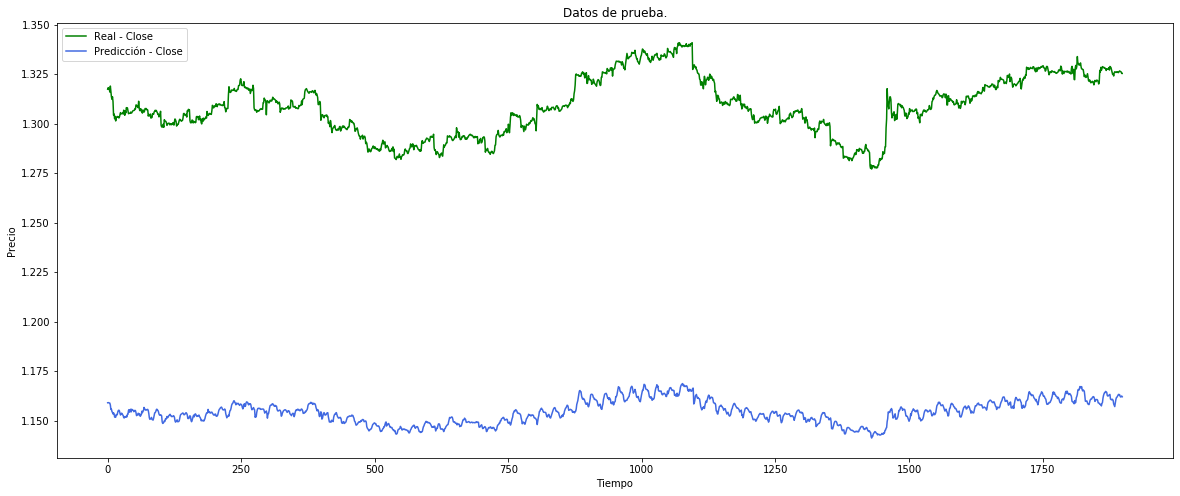

In [89]:
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(20,8))
plt.plot(y_test_np[:], color = 'green', label = 'Real - Close')
plt.plot(y_test_pred[:], color = 'royalblue', label = 'Predicción - Close')
plt.title('Datos de prueba.')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [90]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
#print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error
print('Test R2:',r2_score(y_train_np, y_train_pred))#R2 Score
y_train_np2 = np.delete(y_train_np, -1)
print('Test R2 (-1):',r2_score(y_train_np2, y_train_pred[1:]))#R2 Score

Train MAE: 0.14441250249186602
Train RMSE: 0.14591457521521883
Train MSE: 0.021291063260237754
Test R2: -18.186725060126406
Test R2 (-1): -18.18424229643778


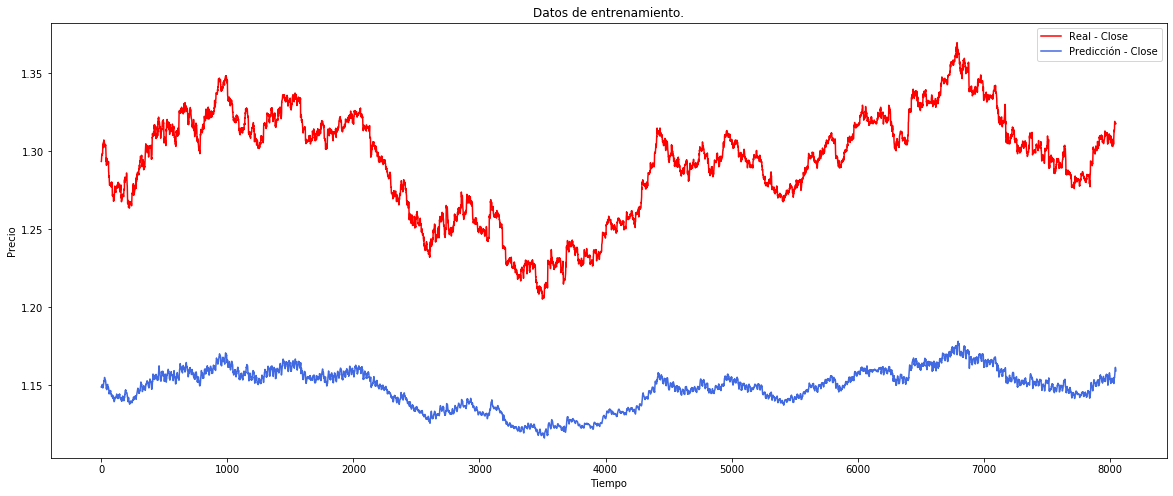

In [91]:
# Visualising the results
plt.figure(figsize=(20,8))
plt.plot(y_train_np, color = 'red', label = 'Real - Close')
plt.plot(y_train_pred, color = 'royalblue', label = 'Predicción - Close')
plt.title('Datos de entrenamiento.')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()